In [417]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

## load data + cleaning

In [418]:

def first_aid(df):
    temp = 'data/'+df+'.csv'
    df = pd.read_csv(temp , sep =',', names = list(range(0,30)))
    df = df[[4,0,5,1,2,3]+list(range(6,29))]
    df[5] = df[5].map(lambda x: x.lstrip('מספר תגובות -'))
    df.columns = ['url','data','number_comment','name','title',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
    return df

pain = first_aid('pain')
bowel_diseases = first_aid('bowel_diseases')
joints = first_aid('joints')
psoriasis = first_aid('psoriasis')
sclerosis = first_aid('sclerosis')

pain1 = pain

## organize data + future engineer
### Collect names in one column

In [419]:
def isNaN(num):
    #check if isNaN
    return num != num
def extract_name(dat,i,j):
    #get a cell, and extracts the name and response
    if not isinstance(dat,str):
        print('Mistake at point'+ str(i)+' ' + str(j) + 'Does not send string')
        return ['','']
    x1 = dat.find('XX')
    x2 = dat.rfind('XX')
    if x1 or x2 <0:
        print("Can't find Name"+ str(i) + "," + str(j))
        return['','']
    name = dat[x1+2:x2]
    text = dat[x2+2:]
    if len(name) > 30:
        print("Can't extract Name"+ str(i) + "," + str(j))
        return ['','']
    return [name,text]

def listToString(s):
    str1 = ""
    for ele in s:
        str1 += ele
        str1 += ","
    return str1
def organize_name(df):
    #Gets DF and deletes the responses from the names and centers them in one cell
    dim = df.shape
    for i in range(0,dim[0]):
        name = [df.loc[i,'name']]
        for j in range(6,dim[1]):
            dat = df.iloc[i,j]
            if not isNaN(dat):
                save_cell = extract_name(dat,i,j)
                df.iloc[i,j] = save_cell[1]
                name.append(save_cell[0])
            else:
                break
        df.loc[i,'name'] = listToString(name)
    return df
pain = organize_name(pain)
bowel_diseases = organize_name(bowel_diseases)
joints = organize_name(joints)
psoriasis = organize_name(psoriasis)
sclerosis = organize_name(sclerosis)

Can't extract Name121,9
Can't extract Name361,11
Can't extract Name2186,6
Can't extract Name353,28
Can't extract Name1134,9
Can't extract Name1455,22
Can't extract Name1455,24


## Visualization data

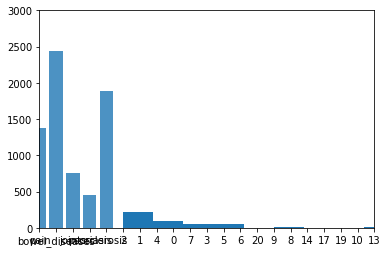

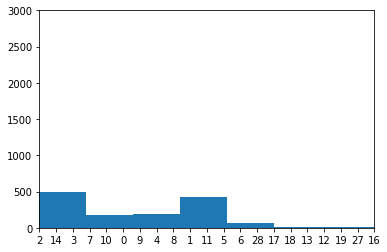

In [462]:
table = [pain,bowel_diseases,joints,psoriasis,sclerosis]
x = []
for df in table:
    x.append(df.shape[0])
y=['pain','bowel_diseases','joints','psoriasis','sclerosis']
plt.bar(y, x, align='center', alpha=0.8)

def hist_comment(df):
    save = df['number_comment'].tolist()
    plt.hist(save)
    plt.axis([0, 20, 0, 3000])
    plt.show()
    # TODO: Can you make the graph look prettier? I get in trouble with that
hist_comment(psoriasis)
hist_comment(pain)



### Functions for the future

In [422]:
def return_phd(cell):
#Looking in the comments who of the writers is a PhD
#return
    cell = cell.split(',')
    save = []
    for i,name in enumerate(cell):
        temp = re.sub(r'[^\w]', ' ', name)
        if "ד ר" in temp or "PhD" in temp:
            save.append(i)
            print(i)
    return save

